In [1]:
#######################################
# CS 424 - Project 2
# Kevin Kowalski
# Samuel Kajah
# Vijay Vemu
#######################################
#
# This file contains the code to clean
# the original data set. It outputs
# the necessary plots and updated data
# set to be used by shiny.
#
# This file was used for testing and 
# plotting before using RStudio for a
# dashboard.
#
#######################################

In [2]:
# import libraries
library(comprehenr)
library(dplyr)
library(hashmap)
library(leaflet)
library(lubridate)
library(stringr)
library(ggplot2)

Warning message:
“package ‘comprehenr’ was built under R version 3.5.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘leaflet’ was built under R version 3.5.2”

Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date


Warning message:
“package ‘stringr’ was built under R version 3.5.2”
Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”


In [3]:
# create appropriate column names for data in the following format
"
data rows
col 1 – date YYYYmmDD
col 2 – time HHMM
col 3 – record identifier (factor)
col 4 – storm type (factor)
col 5 – latitude (n/s)
col 6 – longitude (e/w)
col 7 – Maximum sustained wind (in knots)
col 8 – Minimum Pressure (in millibars)
col 9 – 34 kt wind radii maximum extent in northeastern quadrant (in nautical miles) 
col 10 – 34 kt wind radii maximum extent in southeastern quadrant (in nautical miles) 
col 11 – 34 kt wind radii maximum extent in southwestern quadrant (in nautical miles) 
col 12 – 34 kt wind radii maximum extent in northwestern quadrant (in nautical miles) 
col 13 – 50 kt wind radii maximum extent in northeastern quadrant (in nautical miles) 
col 14 – 50 kt wind radii maximum extent in southeastern quadrant (in nautical miles) 
col 15 – 50 kt wind radii maximum extent in southwestern quadrant (in nautical miles) 
col 16 – 50 kt wind radii maximum extent in northwestern quadrant (in nautical miles) 
col 17 – 64 kt wind radii maximum extent in northeastern quadrant (in nautical miles)
col 18 – 64 kt wind radii maximum extent in southeastern quadrant (in nautical miles)
col 19 – 64 kt wind radii maximum extent in southwestern quadrant (in nautical miles) 
col 20 – 64 kt wind radii maximum extent in northwestern quadrant (in nautical miles)
"

data_row_header = c('Date', 'Time', 'Record_ID', 'Storm_Type', 'Lat', 'Lon', 'Speed', 'Pressure', 
                   'Wind_Radii_NE_34', 'Wind_Radii_SE_34', 'Wind_Radii_SW_34', 'Wind_Radii_NW_34',
                   'Wind_Radii_NE_50', 'Wind_Radii_SE_50', 'Wind_Radii_SW_50', 'Wind_Radii_NW_50',
                   'Wind_Radii_NE_64', 'Wind_Radii_SE_64', 'Wind_Radii_SW_64', 'Wind_Radii_NW_64', 'Size')

[1] "\ndata rows\ncol 1 – date YYYYmmDD\ncol 2 – time HHMM\ncol 3 – record identifier (factor)\ncol 4 – storm type (factor)\ncol 5 – latitude (n/s)\ncol 6 – longitude (e/w)\ncol 7 – Maximum sustained wind (in knots)\ncol 8 – Minimum Pressure (in millibars)\ncol 9 – 34 kt wind radii maximum extent in northeastern quadrant (in nautical miles) \ncol 10 – 34 kt wind radii maximum extent in southeastern quadrant (in nautical miles) \ncol 11 – 34 kt wind radii maximum extent in southwestern quadrant (in nautical miles) \ncol 12 – 34 kt wind radii maximum extent in northwestern quadrant (in nautical miles) \ncol 13 – 50 kt wind radii maximum extent in northeastern quadrant (in nautical miles) \ncol 14 – 50 kt wind radii maximum extent in southeastern quadrant (in nautical miles) \ncol 15 – 50 kt wind radii maximum extent in southwestern quadrant (in nautical miles) \ncol 16 – 50 kt wind radii maximum extent in northwestern quadrant (in nautical miles) \ncol 17 – 64 kt wind radii maximum extent in northeastern quadrant (in nautical miles)\ncol 18 – 64 kt wind radii maximum extent in southeastern quadrant (in nautical miles)\ncol 19 – 64 kt wind radii maximum extent in southwestern quadrant (in nautical miles) \ncol 20 – 64 kt wind radii maximum extent in northwestern quadrant (in nautical miles)\n"

In [4]:
# rename original text files to easier-to-work-with CSV files
file.rename("hurdat2-1851-2018-120319.txt", "atlantic_hurricanes.csv")
file.rename("hurdat2-nepac-1949-2018-122019.txt", "pacific_hurricanes.csv")

[1] TRUE

[1] TRUE

In [5]:
# read in the renamed CSV files
atlantic_data = read.csv('atlantic_hurricanes.csv', header = FALSE, stringsAsFactors = FALSE)
pacific_data = read.csv('pacific_hurricanes.csv', header = FALSE, stringsAsFactors = FALSE)

# apply column names to data
colnames(atlantic_data) = data_row_header
colnames(pacific_data) = data_row_header

In [6]:
# trim the first 6 string columns that contain leading/trailing whitespace
for (col in 1: 6) {
    atlantic_data[, col] = str_trim(atlantic_data[, col])
    pacific_data[, col] = str_trim(pacific_data[, col])
}

In [7]:
# create a new timestamp column containing both date and time
atlantic_data = atlantic_data %>% mutate(Timestamp = parse_date_time(paste(atlantic_data$Date, atlantic_data$Time, sep = ' '), "Ymd HM", tz = 'America/Chicago', quiet = TRUE))
pacific_data = pacific_data %>% mutate(Timestamp = parse_date_time(paste(pacific_data$Date, pacific_data$Time, sep = ' '), "Ymd HM", tz = 'America/Chicago', quiet = TRUE))

In [8]:
# the lat and long are using NESW; change it to positive/negative; because plotting only accepts numbers
# N/E = positive, S/W = negative
remake_coordinates = function(coordinates) {
    result = numeric(length(coordinates)) # empty vector of characters
    i = 1
    for(coordinate in coordinates) {
        bearing_index = nchar(coordinate)
        double_value = substr(coordinate, 1, bearing_index - 1) # get just the digits
        bearing = substr(coordinate, bearing_index, bearing_index) # get the direction
        if (bearing == "N" || bearing == "E") {
            result[i] = as.numeric(double_value)
        } else { # must be South or West
            result[i] = -as.numeric(double_value)
        }
        i = i + 1
    }
    result
}

In [9]:
# update coordinates to plot-friendly values
atlantic_data$Lat = remake_coordinates(atlantic_data$Lat)
atlantic_data$Lon = remake_coordinates(atlantic_data$Lon)
pacific_data$Lat = remake_coordinates(pacific_data$Lat)
pacific_data$Lon = remake_coordinates(pacific_data$Lon)

In [10]:
############################## DATA CLEANER FUNCTIONS ######################
############################## DATA CLEANER FUNCTIONS ######################

# determine's if a particular row begins a header for a hurricane entry (by at having at least 15 NA in its row)
is_header_row = function(row) {
    if (sum(is.na(row)) >= 15) 
        TRUE 
    else 
        FALSE
}

# create a vector of indices of all hurricane header rows
header_locations = function(data) {
    to_vec(
        for(row in 1: nrow(data)) 
            if (is_header_row(data[row, ])) 
                row)
}

# assign a new new unique name to unnamed storms
storm_name_from_header = function(header_df, prefix, id) {
    if (header_df[1, 2] == "UNNAMED") {
        paste(prefix, "STORM", id, sep = " ") # use STORM + id as new name
    } else {
        header_df[1, 2]
    }
}

# Many names are repeated; to give unique names, we'll attach the year to it
# For example, there are 2 "IRMA", but 1 is in 1978 and other is in 2017
# We'll rename them as "IRMA 1978" and "IRMA 2017"
name_freq = hashmap('', 0)

# prefix is for naming unnamed storms
# if prefix is "ATLANTIC" then unnamed storms will be named
# ATLANTIC STORM <storm_id>
make_huricane_data = function(data, header_indices, prefix) {
    tables = list() # keep track of the data associated with each storm
    i = 1
    unnamed_id = 1
    for (row_index in 1: length(header_indices)) {
        row = header_indices[row_index] # get the next header row index
        current_header = data[row, ] # get the header data
        storm_name = storm_name_from_header(current_header, prefix, unnamed_id)
        
        if (name_freq$has_key(storm_name)) {
            # this name has been repeated
            name_freq[[storm_name]] = name_freq[[storm_name]] + 1
        } else {
            name_freq[[storm_name]] = 1
        }
        
        if (current_header[1, 2] == "UNNAMED") {
            # update for next id
            unnamed_id = unnamed_id + 1
        }
        
        if (row_index == length(header_indices)) {
            # at the last header
            tables[[i]] = data[(row + 1): nrow(data), ] %>% # the data is from next row to the end of the data
                mutate(Storm_Name = storm_name) %>% # add the storm name
                mutate(Unique_ID = current_header[1, 1]) %>% # add the storm unique ID
                select(Storm_Name, Unique_ID, Timestamp, everything()) # move new columns to front for better ordering
            # adding these will make it easier to filter data
            
        } else {
            # otherwise, data is from next row to the start of the next header
            next_header = header_indices[row_index + 1]
            tables[[i]] = data[(row + 1): (next_header - 1), ]  %>%
                mutate(Storm_Name = storm_name) %>% # add the storm name
                mutate(Unique_ID = current_header[1, 1]) %>% # add the storm unique ID
                select(Storm_Name, Unique_ID, Timestamp, everything()) # move new columns to front for better ordering
        }
        i = i + 1
    }
    make_unique_names(tables)
}

# Use the hashmap to determine which names are repeated; if so, attach the year to it
make_unique_names = function(storm_data_list) {
    result = list()
    i = 1
    for (storm_data in storm_data_list) {
        storm_name = storm_data$Storm_Name[1] # all are the same name, just need 1
        if (name_freq[[storm_name]] > 1) {
            year = year(storm_data$Timestamp)
            new_name = paste(storm_name, ' ', year)
            storm_data$Storm_Name = new_name
        }
        result[[i]] = storm_data
        i = i + 1
    }
    result
}



# assign a category based on wind speed (in knots) using Saffir-Simpson hurricane wind scale
set_storm_category = function(speeds) {
    result = numeric(length(speeds)) # empty vector of characters
    i = 1
    for (speed in speeds) {
        
        s = as.numeric(speed)
        if (is.na(s)) { # must be missing or n/a data
            result[i] = as.numeric(0)
        } else if (s >= 64 && s <= 82) { # category 1
            result[i] = as.numeric(1)
        } else if (s >= 83 && s <= 95) { # category 2
            result[i] = as.numeric(2)
        } else if (s >= 96 && s <= 112) { # category 3
            result[i] = as.numeric(3)
        } else if (s >= 113 && s <= 136) { # category 4
            result[i] = as.numeric(4)
        } else if (s >= 137) { # category 5
            result[i] = as.numeric(5)
        } else { # must be less than category 1 minimum of 64 knots
            result[i] = as.numeric(0)
        }
        i = i + 1
    }
    result
}

In [11]:
# set storm category based on speed
atlantic_data$Category = set_storm_category(atlantic_data$Speed)
pacific_data$Category = set_storm_category(pacific_data$Speed)

In [12]:
# get list of all indices with hurricane headers
atlantic_header_indices = header_locations(atlantic_data)
pacific_header_indices = header_locations(pacific_data)

In [13]:
# list of dataframes of storms; this wil be the main storage for the data, makes it easy to plot
atlantic_data = make_huricane_data(atlantic_data, atlantic_header_indices, "ATLANTIC") # contains names and name_data
pacific_data = make_huricane_data(pacific_data, pacific_header_indices, "PACIFIC") # contains names and name_data

# if needed, can merge into one list 
#combined_data = c(atlantic_data, pacific_data)

In [14]:
# write the cleaned data to RDS files
saveRDS(atlantic_data, file = "atlantic_data.rds")
saveRDS(pacific_data, file = "pacific_data.rds")

In [15]:
# print head of first storm from both data sets
print("Atlantic Data")
head(atlantic_data[[1]])
print("Pacific Data")
head(pacific_data[[1]])

[1] "Atlantic Data"


,Storm_Name,Unique_ID,Timestamp,Date,Time,Record_ID,Storm_Type,Lat,Lon,Speed,⋯,Wind_Radii_NE_50,Wind_Radii_SE_50,Wind_Radii_SW_50,Wind_Radii_NW_50,Wind_Radii_NE_64,Wind_Radii_SE_64,Wind_Radii_SW_64,Wind_Radii_NW_64,Size,Category
,<chr>,<chr>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>,<dbl>
1,ATLANTIC STORM 1,AL011851,1851-06-25 00:00:00,18510625,0000,,HU,28.0,-94.8,80,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,1
2,ATLANTIC STORM 1,AL011851,1851-06-25 06:00:00,18510625,0600,,HU,28.0,-95.4,80,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,1
3,ATLANTIC STORM 1,AL011851,1851-06-25 12:00:00,18510625,1200,,HU,28.0,-96.0,80,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,1
4,ATLANTIC STORM 1,AL011851,1851-06-25 18:00:00,18510625,1800,,HU,28.1,-96.5,80,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,1
5,ATLANTIC STORM 1,AL011851,1851-06-25 21:00:00,18510625,2100,L,HU,28.2,-96.8,80,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,1
6,ATLANTIC STORM 1,AL011851,1851-06-26 00:00:00,18510626,0000,,HU,28.2,-97.0,70,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,1


[1] "Pacific Data"


,Storm_Name,Unique_ID,Timestamp,Date,Time,Record_ID,Storm_Type,Lat,Lon,Speed,⋯,Wind_Radii_NE_50,Wind_Radii_SE_50,Wind_Radii_SW_50,Wind_Radii_NW_50,Wind_Radii_NE_64,Wind_Radii_SE_64,Wind_Radii_SW_64,Wind_Radii_NW_64,Size,Category
,<chr>,<chr>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>,<dbl>
1,PACIFIC STORM 1,EP011949,1949-06-11 00:00:00,19490611,0000,,TS,20.2,-106.3,45,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,0
2,PACIFIC STORM 1,EP011949,1949-06-11 06:00:00,19490611,0600,,TS,20.2,-106.4,45,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,0
3,PACIFIC STORM 1,EP011949,1949-06-11 12:00:00,19490611,1200,,TS,20.2,-106.7,45,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,0
4,PACIFIC STORM 1,EP011949,1949-06-11 18:00:00,19490611,1800,,TS,20.3,-107.7,45,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,0
5,PACIFIC STORM 1,EP011949,1949-06-12 00:00:00,19490612,0000,,TS,20.4,-108.6,45,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,0
6,PACIFIC STORM 1,EP011949,1949-06-12 06:00:00,19490612,0600,,TS,20.5,-109.4,45,⋯,-999,-999,-999,-999,-999,-999,-999,-999,NA,0


In [17]:

############################## FILTERING STORMS FUNCTIONS ######################
############################## FILTERING STORMS FUNCTIONS ######################

# get a list of storms (spanning) in a given year
get_storms_by_year = function(storm_data_list, year) {
    result = list()
    i = 1
    for (storm_data in storm_data_list) {
        # check wether the given year is in the years cuz a storm may span end of 1 year to start of another
        if (any(year(storm_data$Timestamp) == year)) {
            result[[i]] = storm_data
            i = i + 1
        }
    }
    result
}

# get a list of storms (spanning) in a given day
get_storms_by_day = function(storm_data_list, date_string) {
    # date string should be a string of the form mm/dd/YYYY (same in UI display)
    result = list()
    i = 1
    for (storm_data in storm_data_list) {
        # check if date is in the dates (because a storm can span > 1 day)
        if (any(as.Date(storm_data$Timestamp) == as.Date(date_string, "%m/%d/%Y"))) {
            result[[i]] = storm_data
            i = i + 1
        }
    }
    result
}

# get a storm's data given its name
get_storms_by_name = function(storm_data_list, names) {
    result = list()
    i = 1
    for (storm_data in storm_data_list) {
        # storm_name is all the same for 1 storm, so only need the first 1
        if (any(storm_data$Storm_Name[1]  %in% names)) {
            result[[i]] = storm_data
            i = i + 1
        }
    }
    result
}

# get a list of all storms since the given year
get_storms_since = function(storm_data_list, year) {
    result = list()
    i = 1
    for (storm_data in storm_data_list) {
        # check wether the year is at least what was given
        if (any(year(storm_data$Timestamp) >= year)) {
            result[[i]] = storm_data
            i = i + 1
        }
    }
    result
}

# get a vector of all unique days storms were recorded on
get_all_storm_days = function(storm_data_list) {
    result = vector()
    class(result) = "Date"
    for (storm_data in storm_data_list) {
        result = c(result, as.Date(storm_data$Timestamp))
    }
    result = sort(unique(result), decreasing = TRUE)
    
    strftime(result, format = "%m/%d/%Y")
}

# return both years and days from the list in descending order
get_all_days_and_years = function(storm_data_list){
    years = vector()
    days = vector()
    class(days) = "Date"
    
    for (storm_data in storm_data_list){
        days = c(days, unique(as.Date(storm_data$Timestamp)))
        years = c(years, unique(year(as.Date(storm_data$Timestamp))))
    }
    result = list(years = sort(unique(years), decreasing = TRUE), 
                  days = strftime(sort(unique(days), decreasing = TRUE), format = "%m/%d/%Y"))
    result
}


# get a table of top 10 fastest hurricanes and their max speed for a given data set
get_top_10_storms = function(storm_data_list) {
    indices = list() # keep track of indices of the storms in the list
    speeds = list() # keep track of speeds
    i = 1
    for (storm_data in storm_data_list) {
        indices[[i]] = i # store the index
        speeds[[i]] = max(storm_data$Speed) # get the max speed for this storm
        i = i + 1
    }
    index_speed_df = data.frame(index = unlist(indices), speed = unlist(speeds)) %>% arrange(desc(speed))
    result = list()
    i = 1
    for (index in index_speed_df$index[1:10]) {
        result[[i]] = storm_data_list[[index]]
        i = i + 1
    }
    result
}

# get a list of all storm names
get_storm_names = function(storm_data_list) {
    result = character(length(storm_data_list))
    i = 1
    for (storm_data in storm_data_list) {
        result[i] = storm_data$Storm_Name[1] # just need the first item cuz all same
        i = i + 1
    }
    result
}


# get a table of hurricanes which made landfall for a given data set
get_storms_landfall = function(storm_data_list) {
    result = list()
    i = 1
    for (storm_data in storm_data_list) {
        if (any(storm_data$Record_ID == 'L')) {
            result[[i]] = storm_data
            i = i + 1
        }
    }
    result
}

# get a table of hurricanes which DID NOT make landfall for a given data set
get_storms_no_landfall = function(storm_data_list) {
    result = list()
    i = 1
    for (storm_data in storm_data_list) {
        
        if (all(storm_data$Record_ID != 'L')) {
            result[[i]] = storm_data
            i = i + 1
        }
    }
    result
}


In [18]:
###########################
### Example Plots Below ###
###########################

In [19]:
# plot a single storm's path on a map by its size
plot_storm_path_by_size = function(storm_data, color) { # very simple plots, but will customize later
    map_object = leaflet() %>% addTiles()
        if (nrow(storm_data) == 1) { # only 1 coordinate
            map_object %>% 
            addCircleMarkers(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, radius = (storm_data$Speed / 20)) # add markers for size, replace radius with desired circle scaler
        } else {
            map_object %>% 
                addCircleMarkers(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, radius = (storm_data$Speed / 20)) %>% # add markers for size, replace radius with desired circle scaler
                addPolylines(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, weight = storm_data$Size) #%>%
                #addMarkers(data = storm_data, lng= ~Lon, lat= ~Lat)
        }
}

# plot multiple storm paths on a map by their size
plot_multi_storm_path_by_size = function(storm_data_list, color_list) {
    map_object = leaflet() %>% addTiles()
    for(i in 1: length(storm_data_list)) {
        storm_data = storm_data_list[[i]]
        color = color_list[i]
        if (nrow(storm_data) == 1) { # only 1 coordinate
            map_object = map_object %>% 
                addCircleMarkers(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, radius = (storm_data$Speed / 20)) # add markers for size, replace radius with desired circle scaler
        } else {
            map_object = map_object %>% 
                addCircleMarkers(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, radius = (storm_data$Speed / 20)) %>% # add markers for size, replace radius with desired circle scaler
                addPolylines(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, weight = storm_data$Size) # %>% 
                # addMarkers(data=storm_data, lng= ~lon, lat= ~lat)
        }
    }
    map_object
}

# !!! all hurricanes have N/A in Size column, so using scaled down speed to plot size of hurricane at each point of its path

In [16]:
# plot multiple storm paths on a map by their size
plot_multi_storm_path_by_size = function(storm_data_list, color_list) {
    map_object = leaflet() %>% addTiles()
    for(i in 1: length(storm_data_list)) {
        storm_data = storm_data_list[[i]]
        color = color_list[i]
        if (nrow(storm_data) == 1) { # only 1 coordinate
            map_object = map_object %>% 
                addCircleMarkers(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, radius = storm_data$Category) # add markers for size, replace radius with desired circle scaler
        } else {
            map_object = map_object %>% 
                addCircleMarkers(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, radius = storm_data$Category) %>% # add markers for size, replace radius with desired circle scaler
                addPolylines(data = storm_data, lat = ~Lat, lng = ~Lon, color = color, weight = storm_data$Category) # %>% weight = storm_data$Size
            # addMarkers(data=storm_data, lng= ~lon, lat= ~lat)
        }
    }
    map_object
}

In [20]:
# get the data for the storm named HIKI and plot its path on a map by size
plot_multi_storm_path_by_size(get_storms_by_name(pacific_data, 'HIKI'), c("blue"))

HTML widgets cannot be represented in plain text (need html)

In [21]:
# plot Atlantic storms by size from 2018
colors = c("red", "blue", "gray", "pink", "purple", "black", "aqua", "royalblue",
           "yellow", "brown", "green", "turquoise", "skyblue", "fuscia", "white", "orange")
plot_multi_storm_path_by_size(get_storms_by_year(atlantic_data, 2018), colors)

HTML widgets cannot be represented in plain text (need html)

In [22]:
################################
### Ordering Functions Below ###
################################

In [23]:

# get a list of all storm names chronologically (which should be default ordering)
get_storm_names_chronologically = function(storm_data_list) {
    table = list()
    i = 1
    for (storm_data in storm_data_list) {
        table[[i]] = storm_data$Storm_Name[1]
        i = i + 1
    }
    
    # build dataframe of each hurricane by name
    df <- data.frame(matrix(unlist(table), nrow = length(table), byrow = T), stringsAsFactors = FALSE)
    names(df)[1] <- "Storm_Name"
    
    # should be sorted in chronological order by default so return the ordered list of names
    df$Storm_Name
}

# get a list of all storm names alphabetically
get_storm_names_alphabetically = function(storm_data_list) {
    sort(unlist(get_storm_names(storm_data_list)))
}

# get a list of all storm names by max speed given low/high
get_storm_names_max_speed = function(storm_data_list, low, high) {
    table = list()
    i = 1
    for (storm_data in storm_data_list) {
        table[[i]] = c(storm_data$Storm_Name[1], max(storm_data$Speed))
        i = i + 1
    }
    # build dataframe of each hurricane and its top speed
    df <- data.frame(matrix(unlist(table), nrow = length(table), byrow = T), stringsAsFactors = FALSE)
    names(df)[1] <- "Storm_Name"
    names(df)[2] <- "TopSpeed"
    df$TopSpeed <- as.numeric(df$TopSpeed)
    
    # if parameters for low of range specified
    if (missing(low) == FALSE) {
        
        # remove out of range values from dataframe
        df <- filter(df, TopSpeed >= low)
    }
    
    # if parameters for high of range specified
    if (missing(high) == FALSE) {
        
        # remove out of range values from dataframe
        df <- filter(df, TopSpeed <= high)
    }
    
    # sort in descending order and return the ordered list of names
    df <- df[order(-df$TopSpeed), ]
    df$Storm_Name
}

# get a table of hurricanes in order by min pressure for a given data set in pressure range of low to high
get_storm_names_min_pressure = function(storm_data_list, low, high) {
    table = list()
    i = 1
    for (storm_data in storm_data_list) {
        table[[i]] = c(storm_data$Storm_Name[1], min(storm_data$Pressure))
        i = i + 1
    }
    
    # build dataframe of each hurricane and its min pressure
    df <- data.frame(matrix(unlist(table), nrow = length(table), byrow = T), stringsAsFactors = FALSE)
    names(df)[1] <- "Storm_Name"
    names(df)[2] <- "MinPressure"
    df$MinPressure <- as.numeric(df$MinPressure)
    
    # if parameters for low of range specified
    if (missing(low) == FALSE) {
        
        # remove out of range values from dataframe
        df <- filter(df, MinPressure >= low)
    }
    
    # if parameters for high of range specified
    if (missing(high) == FALSE) {
        
        # remove out of range values from dataframe
        df <- filter(df, MinPressure <= high)
    }
    
    # sort in ascending order and return the ordered list of names
    df <- df[order(df$MinPressure), ]
    df$Storm_Name
}

In [24]:
# output count and chronological order of atlantic hurricanes
chrono_order <- get_storm_names_chronologically(atlantic_data)
length(chrono_order)
chrono_order[1:10]

[1] 1873

[1] "ATLANTIC STORM 1"  "ATLANTIC STORM 2"  "ATLANTIC STORM 3" 
 [4] "ATLANTIC STORM 4"  "ATLANTIC STORM 5"  "ATLANTIC STORM 6" 
 [7] "ATLANTIC STORM 7"  "ATLANTIC STORM 8"  "ATLANTIC STORM 9" 
[10] "ATLANTIC STORM 10"

In [25]:
# output count and alphabetical order of atlantic hurricanes
alpha_order <- get_storm_names_alphabetically(atlantic_data)
length(alpha_order)
alpha_order[1:10]

[1] 1873

[1] "ABBY   1960"    "ABBY   1964"    "ABBY   1968"    "ABLE   1950"   
 [5] "ABLE   1951"    "ABLE   1952"    "AGNES"          "ALBERTO   1982"
 [9] "ALBERTO   1988" "ALBERTO   1994"

In [26]:
# output count and order of atlantic hurricanes by top speed
speed_order <- get_storm_names_max_speed(atlantic_data)
length(speed_order)
speed_order[1:10]

[1] 1873

[1] "ALLEN"              "ATLANTIC STORM 654" "GILBERT"           
 [4] "WILMA"              "MITCH"              "RITA"              
 [7] "IRMA   2017"        "ATLANTIC STORM 617" "JANET"             
[10] "CAMILLE"

In [27]:
# output count and order of atlantic hurricanes by min pressure
pressure_order <- get_storm_names_min_pressure(atlantic_data)
length(pressure_order)
pressure_order[1:10]

[1] 1873

[1] "ATLANTIC STORM 1"  "ATLANTIC STORM 2"  "ATLANTIC STORM 3" 
 [4] "ATLANTIC STORM 4"  "ATLANTIC STORM 5"  "ATLANTIC STORM 6" 
 [7] "ATLANTIC STORM 7"  "ATLANTIC STORM 8"  "ATLANTIC STORM 9" 
[10] "ATLANTIC STORM 10"

In [28]:
#Combine both list of dataframes to make a "master list"
combined_data = c(atlantic_data, pacific_data)

Warning message:
“Use of `binded_rows$Timestamp` is discouraged. Use `Timestamp` instead.”


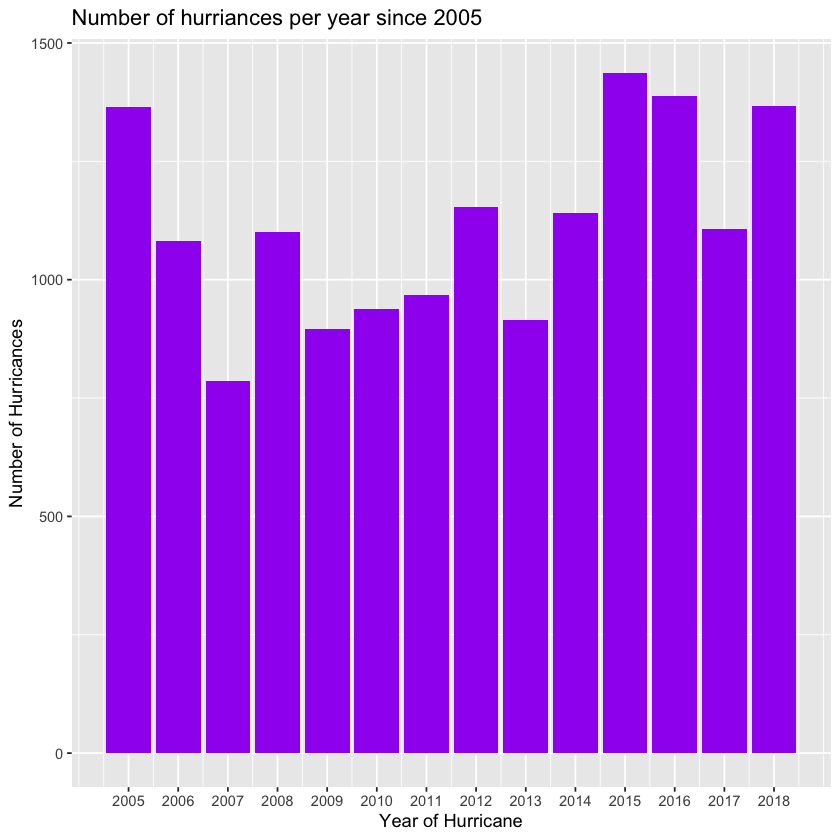

In [29]:
# Filter out those which took place before 2005 and store in new list of dataframes
post2005_combined_data <- get_storms_since(combined_data, 2005)

# Bind rows to make it easier to plot
binded_rows <- bind_rows(post2005_combined_data, .id="df")

# Plot number of hurricances which took place per year
ggplot(binded_rows, aes(x = year(binded_rows$Timestamp))) + geom_bar(fill = "purple") + labs(title = "Number of hurriances per year since 2005", x = "Year of Hurricane", y = "Number of Hurricances") + scale_x_continuous(breaks=2005:2018)


In [54]:
# get a table of hurricanes in order by top speed for a given data set
get_storm_names_max_speed_table = function(storm_data_list) {
    table = list()
    i = 1
    for (storm_data in storm_data_list) {
        table[[i]] = c(storm_data$Storm_Name[1], strftime(storm_data$Timestamp, "%m/%d/%Y")[2], max(storm_data$Speed), min(storm_data$Pressure))
        i = i + 1
    }
    
    # build dataframe of each hurricane and its top speed
    df <- data.frame(matrix(unlist(table), nrow = length(table), byrow = T), stringsAsFactors = FALSE)
    names(df)[1] <- "Storm_Name"
    names(df)[2] <- "Timestamp"
    names(df)[3] <- "TopSpeed"
    names(df)[4] <- "MinPressure"
    df$TopSpeed <- as.numeric(df$TopSpeed)
    df$Timestamp <- parse_date_time(df$Timestamp,"%m/%d/%Y", tz = 'America/Chicago', quiet = TRUE)
    df$MinPressure <- as.numeric(df$MinPressure)
    # sort in descending order and return the ordered list of names
    df <- df[order(-df$TopSpeed), ]
    df
}



In [55]:
get_storm_names_max_speed_table(atlantic_data)[1:10,]

,Storm_Name,Timestamp,TopSpeed,MinPressure
,<chr>,<dttm>,<dbl>,<dbl>
1279,ALLEN,1980-07-31,165,-999
654,ATLANTIC STORM 654,1935-08-29,160,-999
1395,GILBERT,1988-09-09,160,888
1666,WILMA,2005-10-16,160,882
1537,MITCH,1998-10-22,155,905
1659,RITA,2005-09-18,155,895
1849,IRMA 2017,2017-08-30,155,914
617,ATLANTIC STORM 617,1932-10-30,150,-999
885,JANET,1955-09-21,150,-999


Warning message:
“Use of `filtered_category$Category` is discouraged. Use `Category` instead.”


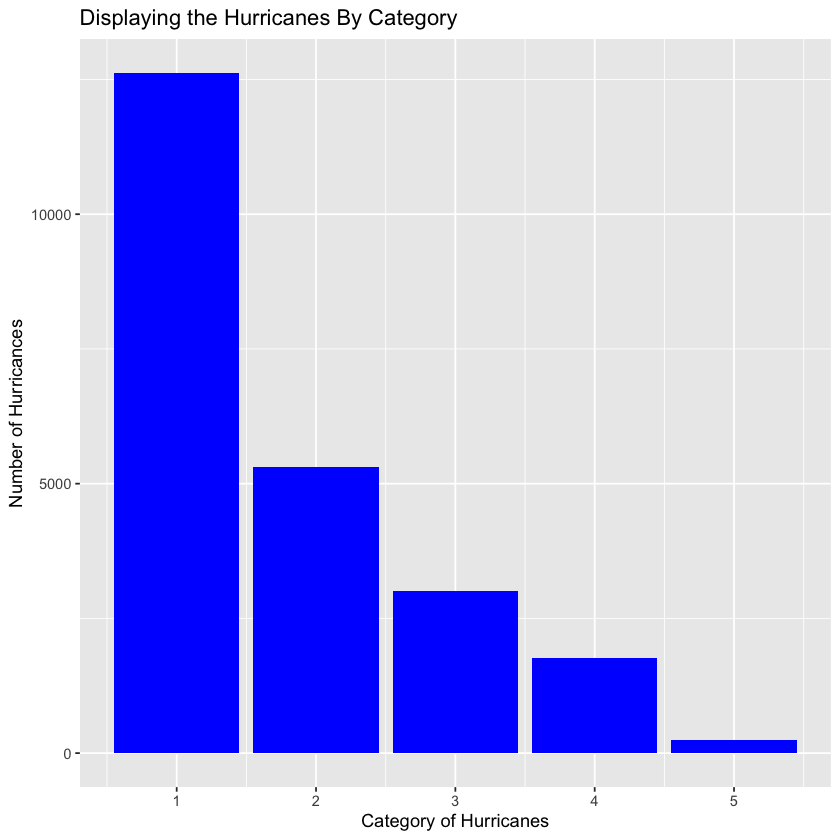

In [56]:
binded_rows_for_category <- bind_rows(combined_data, .id="df")
filtered_category <- binded_rows_for_category[which(binded_rows_for_category$Category != 0),]
# Plotting the hurricanes in the data by strength category
ggplot(filtered_category, aes(x = filtered_category$Category)) + geom_bar(fill = "blue") + labs(title = "Displaying the Hurricanes By Category", x = "Category of Hurricanes", y = "Number of Hurricances") + scale_x_continuous(breaks=0:5)

In [65]:
AtlanticMaxSpeed <- get_storm_names_max_speed_table(atlantic_data)
PacificMaxSpeed <- get_storm_names_max_speed_table(pacific_data)

In [74]:
plotWindForYear <- function(year)
    {
        AtlanticMaxSpeedForYear <- AtlanticMaxSpeed[which(year(AtlanticMaxSpeed$Timestamp)== year),]
        PacfificMaxSpeedForYear <- PacificMaxSpeed[which(year(PacificMaxSpeed$Timestamp)== year),]


    
        ggplot() + geom_line(data = AtlanticMaxSpeedForYear, aes(x = date(Timestamp), y = TopSpeed), color = "blue") +
      geom_line(data = PacfificMaxSpeedForYear, aes(x = date(Timestamp), y = TopSpeed), color = "red") +
      xlab('Day') +
      ylab('Min Speed')

    }




In [77]:
plotPressureForYear <- function(year)
{
        AtlanticMaxSpeedForYear <- AtlanticMaxSpeed[which(year(AtlanticMaxSpeed$Timestamp)== year),]
        PacfificMaxSpeedForYear <- PacificMaxSpeed[which(year(PacificMaxSpeed$Timestamp)== year),]
    
        ggplot() + geom_line(data = AtlanticMaxSpeedForYear, aes(x = date(Timestamp), y = MinPressure), color = "blue") +
          geom_line(data = PacfificMaxSpeedForYear, aes(x = date(Timestamp), y = MinPressure), color = "red") +
          xlab('Day') +
          ylab('Min Pressure')
        
    
}

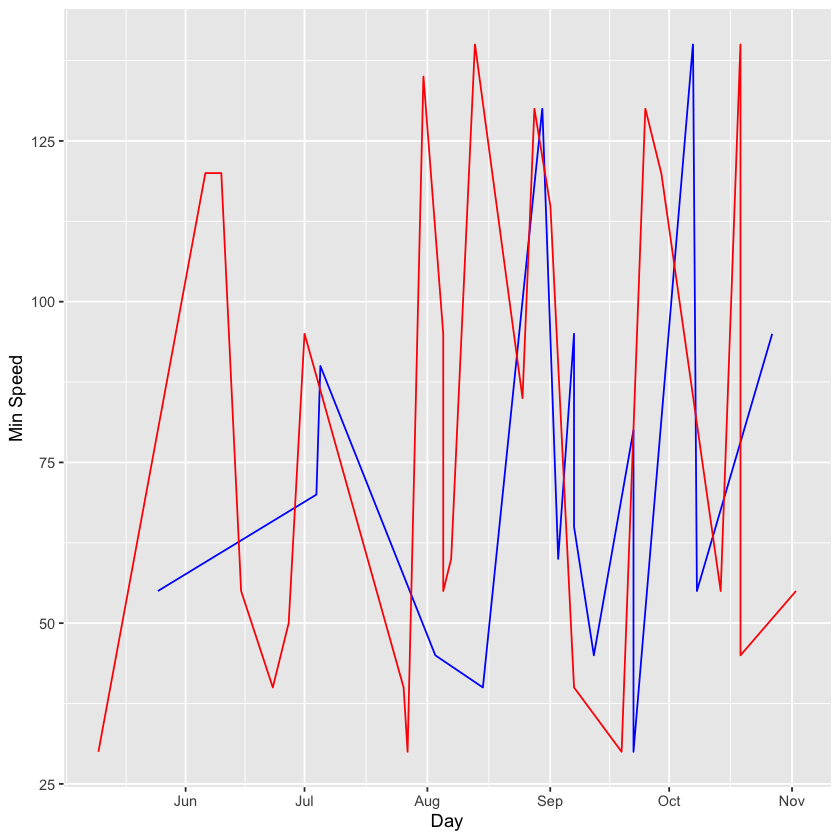

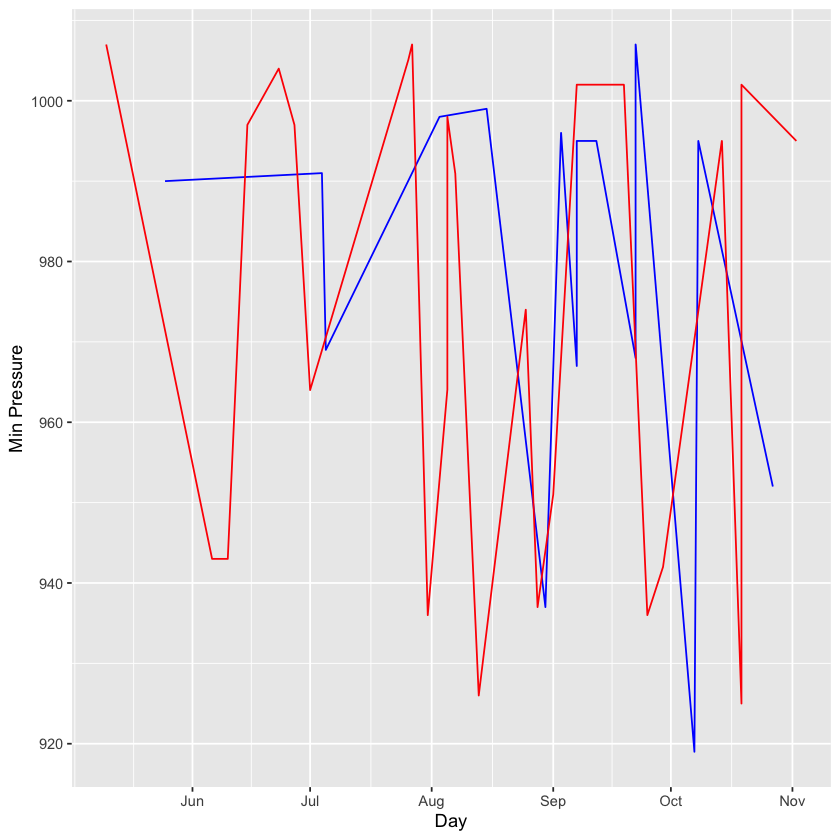

In [78]:
plotWindOrSpeed(2018)
plotPressureForYear(2018)